# Make sure to to set runtime to GPU to speed up hyperparameter optimization

In [1]:
!pip install tensorflow_addons
!pip install keras-tuner --upgrade

# clone minape repository, refresh folder to see the minape repository
# runtime -> change runtime -> choose gpu/tpu
!git clone https://github.com/hubtru/Minape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.3 MB/s eta 0:00:00
Cloning into 'Minape'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 3 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 47.82 MiB | 15.53 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow_addons as tfa
import keras_tuner

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
#Variables
image_size = 256
in_channel_tool = 3
num_classes = 3
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 40
num_epochs = 100

In [4]:
#Functions
#Multimodal implementation of Trockman, A., & Kolter, J. Z. (2022). Patches are all you need?.
#https://github.com/locuslab/convmixer
#Convert images to numpy array

def read_tools(file_paths, image_size, channels):
  images = []

  for file_path in file_paths:
    img = cv2.imread(file_path)
    res = cv2.resize(img, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    images.append(res)

  images = np.asarray(images, dtype=np.float32)

  # normalize
  images = images / np.max(images)

  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], image_size, image_size, channels)

  return images

#Patch dataset

def generate_datasets(images, is_train=False):
    dataset = images
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto
        )
    return dataset.prefetch(auto)

#Model creation methods

def activation_module(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)


def base_module(x, filters, patch_size):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_module(x)


def multi_mixer_module(x, filters, kernel_size):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_module(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_module(x)

    return x


def load_multi_mixer(hp):

    filters=hp.Int("filters", min_value=128, max_value=512, step=128)
    depth=hp.Int("depth", min_value=4, max_value=8, step=4)
    kernel_size=hp.Int("kernel_size", min_value=3, max_value=9, step=1)
    patch_size=hp.Int("patch_size", min_value=4, max_value=32, step=4)

    inputs = k.Input((image_size, image_size, in_channel_tool))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = base_module(x, filters, patch_size)

    # Multi_mixer modul.
    for _ in range(depth):
        x = multi_mixer_module(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = k.Model(inputs, outputs)

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

#Run experiment

def launch_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = k.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        new_train_dataset,
        validation_data=new_val_dataset,
        epochs=num_epochs,
        shuffle=True,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(new_test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [5]:
#Dataset acquisition

data_path = '/content/Minape/Data/labels_aug/random_distribution'
train_df = pd.read_csv(f'{data_path}/train.csv', index_col=0)
test_df = pd.read_csv(f'{data_path}/test.csv', index_col=0)
val_df = pd.read_csv(f'{data_path}/val.csv', index_col=0)

tool_path = '/content/Minape/Data/dataset_aug/tool'
train_df['tool'] = train_df.index.map(lambda id: f'{tool_path}/{id}.jpg')
test_df['tool'] = test_df.index.map(lambda id: f'{tool_path}/{id}.jpg')
val_df['tool'] = val_df.index.map(lambda id: f'{tool_path}/{id}.jpg')

<Figure size 600x600 with 0 Axes>

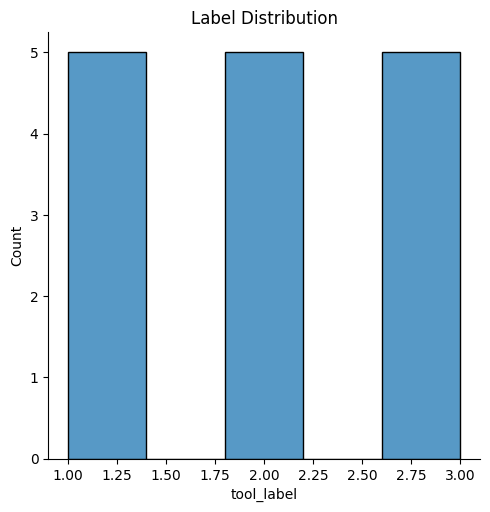

In [6]:
#Plot dataset distribution
plt.figure(figsize=(6,6))
sns.displot(train_df['tool_label'])
plt.title('Label Distribution')
plt.show()

In [7]:
#Read tool images and convert them to NumPy array
x_train_tool = read_tools(train_df.tool.values, image_size, in_channel_tool)
x_test_tool = read_tools(test_df.tool.values, image_size, in_channel_tool)
x_val_tool = read_tools(val_df.tool.values, image_size, in_channel_tool)
#Bring the labels to an acceptable form
labels_train = train_df.tool_label.values - 1
labels_test = test_df.tool_label.values - 1
labels_val = val_df.tool_label.values - 1

In [8]:
#Create tensorflow datasets objects and add patch embedding to train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_tool, labels_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_tool, labels_test))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_tool, labels_val))
train_dataset = train_dataset.shuffle(x_train_tool.shape[0], seed=777)

auto = tf.data.AUTOTUNE

data_augmentation = k.Sequential(
    [layers.RandomCrop(image_size, image_size), k.layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)

new_train_dataset = generate_datasets(train_dataset, is_train=True)
new_val_dataset = generate_datasets(val_dataset)
new_test_dataset = generate_datasets(test_dataset)

In [9]:
#Multi_mixer model architecture optimization
hp = keras_tuner.HyperParameters()

tuner = keras_tuner.RandomSearch(
    hypermodel=load_multi_mixer,
    objective="val_accuracy",
    max_trials=10, # change number of trials here
    seed=None,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True,
    project_name="tool_opt"
)

history_opt = tuner.search(
        new_train_dataset,
        epochs=num_epochs,
        shuffle=True,
        validation_data=new_val_dataset
    )

Trial 10 Complete [00h 03m 46s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.6666666865348816
Total elapsed time: 00h 25m 09s


In [10]:
#Optimization summary #1
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
depth (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 8, 'step': 4, 'sampling': 'linear'}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 9, 'step': 1, 'sampling': 'linear'}
patch_size (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}


In [11]:
#Optimization summary #2
tuner.results_summary()

Results summary
Results in ./tool_opt
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
filters: 512
depth: 4
kernel_size: 8
patch_size: 28
Score: 0.6666666865348816

Trial 07 summary
Hyperparameters:
filters: 512
depth: 4
kernel_size: 4
patch_size: 24
Score: 0.6666666865348816

Trial 00 summary
Hyperparameters:
filters: 256
depth: 8
kernel_size: 5
patch_size: 8
Score: 0.3333333432674408

Trial 01 summary
Hyperparameters:
filters: 384
depth: 4
kernel_size: 3
patch_size: 28
Score: 0.3333333432674408

Trial 02 summary
Hyperparameters:
filters: 384
depth: 4
kernel_size: 6
patch_size: 28
Score: 0.3333333432674408

Trial 03 summary
Hyperparameters:
filters: 384
depth: 4
kernel_size: 6
patch_size: 24
Score: 0.3333333432674408

Trial 04 summary
Hyperparameters:
filters: 256
depth: 8
kernel_size: 7
patch_size: 32
Score: 0.3333333432674408

Trial 05 summary
Hyperparameters:
filters: 128
depth: 4
kernel_size: 8
patch_size: 20
Score: 0.33333

In [12]:
#Choose the best model based on architecture optimization
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.build(input_shape=(image_size, image_size, in_channel_tool))
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 9, 9, 512)            1204736   ['rescaling[0][0]']           
                                                                                                  
 activation (Activation)     (None, 9, 9, 512)            0         ['conv2d[0][0]']              
                                                                                              

In [13]:
#Choose the best hyperparameters
best_hps = tuner.get_best_hyperparameters(5)
model = load_multi_mixer(best_hps[0])

In [14]:
#Train optimized architecture
history, conv_mixer_model = launch_experiment(model)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.3085 - accuracy: 0.2000 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 2/100
1/1 [==============================] - 1s 754ms/step - loss: 0.6735 - accuracy: 0.8000 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 1s 949ms/step - loss: 0.6432 - accuracy: 0.7333 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.2226 - accuracy: 0.9333 - val_loss: 1.1002 - val_accuracy: 0.3333
Epoch 5/100
1/1 [==============================] - 1s 860ms/step - loss: 0.2147 - accuracy: 0.9333 - val_loss: 1.1012 - val_accuracy: 0.3333
Epoch 6/100
1/1 [==============================] - 1s 722ms/step - loss: 0.0699 - accuracy: 1.0000 - val_loss: 1.1019 - val_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 1s 711ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 1.1027 - val_accuracy: 0.3333
Epoch 8/100
1/1 [==

In [15]:
#Save model
model_path = '/content/Minape/models_rep'
conv_mixer_model.save(f"{model_path}/tool_aug_tool_opt.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


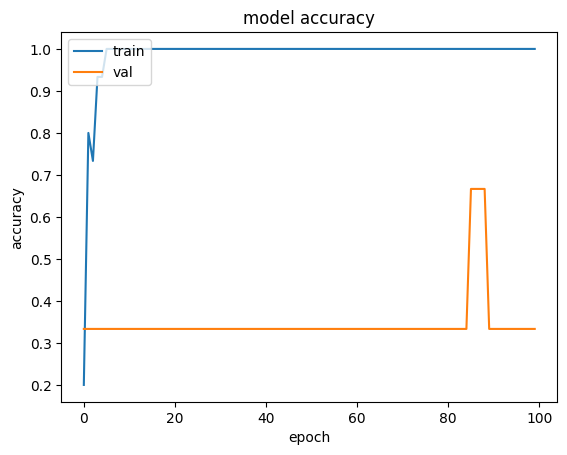

In [16]:
#Plot accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

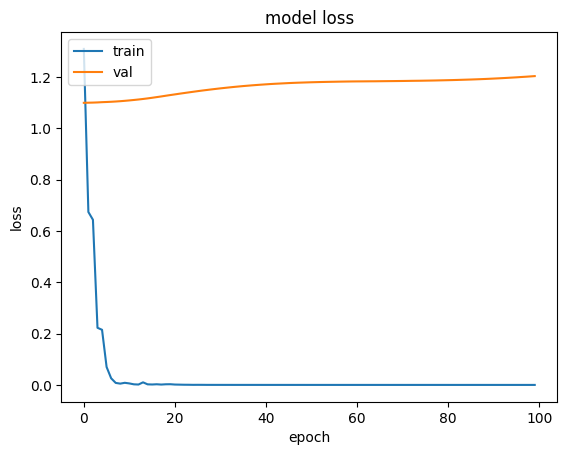

In [18]:
#Plot loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()